In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss

In [2]:
# Load the data
train_path = 'train_smote.csv'
test_path = 'test.csv'
val_path = 'val.csv'
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
val = pd.read_csv(val_path)
# Display the first few rows of the dataframe to understand its structure
train.head()

,ID,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Drug,Sex,Ascites,Hepatomegaly,Spiders,Edema,Status
0,99,1.617184,-0.146800,-0.321927,0.409636,-0.405516,0.590972,-0.238964,-0.248308,-0.108401,-0.947607,-0.524219,-1.177506,1,1,1,1,1,1,1
1,155,0.588185,-0.611734,-0.587234,-0.676818,-0.405516,-0.477086,-0.169707,0.545741,-0.723014,0.518002,0.473076,1.104369,1,0,1,0,0,2,1
2,116,1.185611,1.046118,-0.056619,0.400582,0.262393,-0.277559,-0.184681,-0.275689,4.161549,1.857083,-0.823408,-0.036569,0,0,1,1,0,2,1
3,271,-0.389987,0.042906,-0.498798,-0.219602,-0.047708,-0.042821,-0.480897,-0.204145,0.845868,0.286035,-1.022867,-0.036569,1,0,1,0,1,1,1
4,184,-0.920536,-1.174891,1.712099,1.378390,0.071562,3.055723,0.200914,0.792171,0.247429,2.205033,-0.923137,-0.036569,1,0,1,0,1,1,0


In [3]:
# Separate the features and the target variable
X_train = train.drop(['ID', 'Status'], axis=1)
y_train = train['Status']
X_test = test.drop(['ID', 'Status'], axis=1)
y_test = test['Status']
X_val = val.drop(['ID', 'Status'], axis=1)
y_val = val['Status']
X_train_val = pd.concat([X_train, X_val], ignore_index=True)
y_train_val = pd.concat([y_train, y_val], ignore_index=True)

# Check the size of each set to confirm the split ratio
len(X_train), len(X_val), len(X_train_val), len(X_test)

(357, 47, 404, 47)

In [4]:
# Define the parameter grid to search
param_grid = {
    'onevsrestclassifier__estimator__C': [0.01, 0.1, 1, 10, 100],
    'onevsrestclassifier__estimator__penalty': ['l1', 'l2'],
    'onevsrestclassifier__estimator__solver': ['liblinear', 'sag', 'saga', 'lbfgs']
}

# Define the model for grid search
model_gs = make_pipeline(StandardScaler(), OneVsRestClassifier(LogisticRegression(random_state=42)))

# Setup the grid search with cross-validation
grid_search = GridSearchCV(model_gs, param_grid, cv=5, scoring='accuracy', verbose=1)

# Fit grid search on the train+validation set
grid_search.fit(X_train_val, y_train_val)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_params, best_score

Fitting 5 folds for each of 40 candidates, totalling 200 fits


/Users/mac/opt/anaconda3/envs/csci567_2/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mac/opt/anaconda3/envs/csci567_2/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mac/opt/anaconda3/envs/csci567_2/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mac/opt/anaconda3/envs/csci567_2/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mac/opt/anaconda3/envs/csci567_2/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  

({'onevsrestclassifier__estimator__C': 0.1,
  'onevsrestclassifier__estimator__penalty': 'l2',
  'onevsrestclassifier__estimator__solver': 'sag'},
 0.8094753086419754)

In [5]:
# Re-create the model with the best parameters found from grid search
best_model = make_pipeline(
    StandardScaler(),
    OneVsRestClassifier(LogisticRegression(
        C=best_params['onevsrestclassifier__estimator__C'],
        penalty=best_params['onevsrestclassifier__estimator__penalty'],
        solver=best_params['onevsrestclassifier__estimator__solver'],
        random_state=42
    ))
)

# Fit the model with the best parameters on the entire training and validation set
best_model.fit(X_train_val, y_train_val)

# Predict on the test set
y_test_pred = best_model.predict(X_test)

# Calculate the accuracy on the test set
accuracy_test = accuracy_score(y_test, y_test_pred)

accuracy_test

0.7659574468085106

In [6]:
# Calculate precision, recall, and F1-score for the test set
precision_test = precision_score(y_test, y_test_pred, average='macro', zero_division=1)
recall_test = recall_score(y_test, y_test_pred, average='macro')
f1_test = f1_score(y_test, y_test_pred, average='macro')

print("Precision: {:.2f}".format(precision_test))
print("Recall: {:.2f}".format(recall_test))
print("F1-Score: {:.2f}".format(f1_test))

Precision: 0.64
Recall: 0.63
F1-Score: 0.63


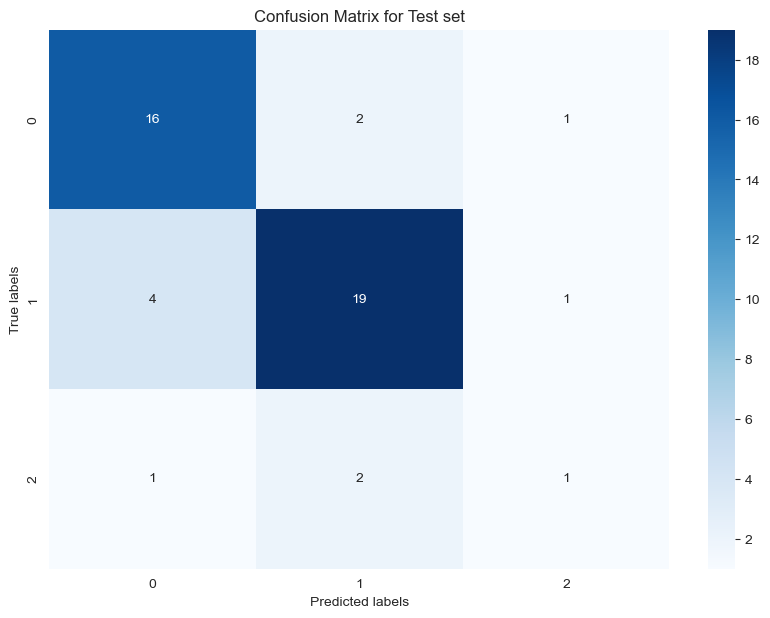

In [7]:
# Calculate confusion matrix
conf_mat = confusion_matrix(y_test, y_test_pred)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat, annot=True, fmt='g', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Test set')
plt.show()

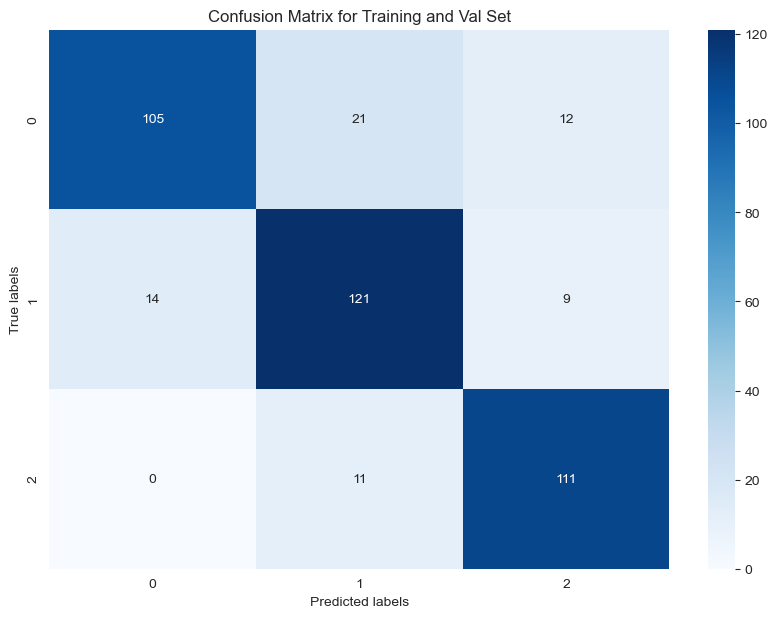

In [8]:
# Predict on the train+validation set to see the performance on the training data
y_train_val_pred = best_model.predict(X_train_val)

# Calculate confusion matrix for the train+validation set
conf_mat_train_val = confusion_matrix(y_train_val, y_train_val_pred)

# Plot the confusion matrix for the train+validation set
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat_train_val, annot=True, fmt='g', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Training and Val Set')
plt.show()

In [9]:
# Get the probability predictions for the test set
y_test_proba = best_model.predict_proba(X_test)
# Clip the probability predictions to avoid log(0) issues
y_test_proba_clipped = np.clip(y_test_proba, 1e-15, 1 - 1e-15)

# Calculate the log loss on the test set again after clipping
logloss_test = log_loss(y_test, y_test_proba_clipped)

logloss_test

0.7083716788243705

In [10]:
# Define a new pipeline with PCA and logistic regression for grid search
pca_lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('logistic_regression', OneVsRestClassifier(LogisticRegression(solver='liblinear', random_state=42)))
])

# Define a new parameter grid, considering PCA components and logistic regression parameters
param_grid_pca_lr = {
    'pca__n_components': [1, 2, 3, 4, 5],
    'logistic_regression__estimator__C': [0.01, 0.1, 1, 10, 100],
    'logistic_regression__estimator__penalty': ['l1', 'l2'],
    'logistic_regression__estimator__solver': ['liblinear', 'sag', 'saga', 'lbfgs']
}

# Setup the grid search with cross-validation
grid_search_pca_lr = GridSearchCV(pca_lr_pipeline, param_grid_pca_lr, cv=5, scoring='accuracy', verbose=1)

# Fit grid search on the train+validation set
grid_search_pca_lr.fit(X_train_val, y_train_val)

# Get the best parameters and the best score from the grid search
best_params_pca_lr = grid_search_pca_lr.best_params_
best_score_pca_lr = grid_search_pca_lr.best_score_

best_params_pca_lr, best_score_pca_lr

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


/Users/mac/opt/anaconda3/envs/csci567_2/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
250 fits failed out of a total of 1000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
125 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/mac/opt/anaconda3/envs/csci567_2/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/mac/opt/anaconda3/envs/csci567_2/lib/python3.8/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/mac/opt/anaconda3/envs/csci567_2/lib/python3.8/site-packages/sklearn/pipeli

({'logistic_regression__estimator__C': 0.1,
  'logistic_regression__estimator__penalty': 'l2',
  'logistic_regression__estimator__solver': 'sag',
  'pca__n_components': 4},
 0.7772222222222223)

In [11]:
# Re-create the model with the best parameters found from the updated grid search
best_pca_lr_model = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=best_params_pca_lr['pca__n_components'])),
    ('logistic_regression', OneVsRestClassifier(LogisticRegression(
        C=best_params_pca_lr['logistic_regression__estimator__C'],
        penalty=best_params_pca_lr['logistic_regression__estimator__penalty'],
        solver=best_params_pca_lr['logistic_regression__estimator__solver'],
        random_state=42
    )))
])

# Fit the model with the best parameters on the entire training and validation set
best_pca_lr_model.fit(X_train_val, y_train_val)

# Predict on the test set
y_test_pred_best_pca_lr = best_pca_lr_model.predict(X_test)

# Calculate the accuracy on the test set
accuracy_test_best_pca_lr = accuracy_score(y_test, y_test_pred_best_pca_lr)

accuracy_test_best_pca_lr

0.7021276595744681

In [12]:
# Calculate precision, recall, and F1-score for the test set
precision_test = precision_score(y_test, y_test_pred, average='macro', zero_division=1)
recall_test = recall_score(y_test, y_test_pred, average='macro')
f1_test = f1_score(y_test, y_test_pred, average='macro')

print("Precision: {:.2f}".format(precision_test))
print("Recall: {:.2f}".format(recall_test))
print("F1-Score: {:.2f}".format(f1_test))

Precision: 0.64
Recall: 0.63
F1-Score: 0.63


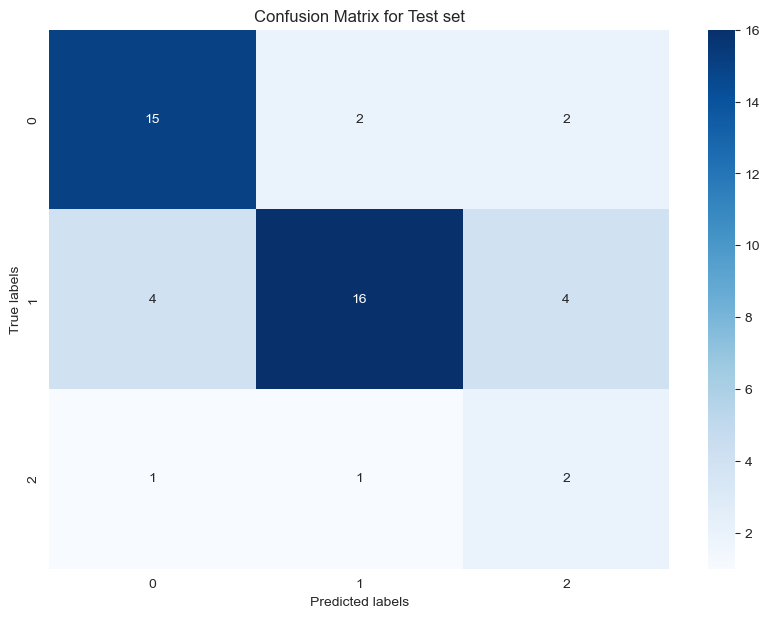

In [13]:
# Calculate confusion matrix
conf_mat = confusion_matrix(y_test, y_test_pred_best_pca_lr)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat, annot=True, fmt='g', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Test set')
plt.show()

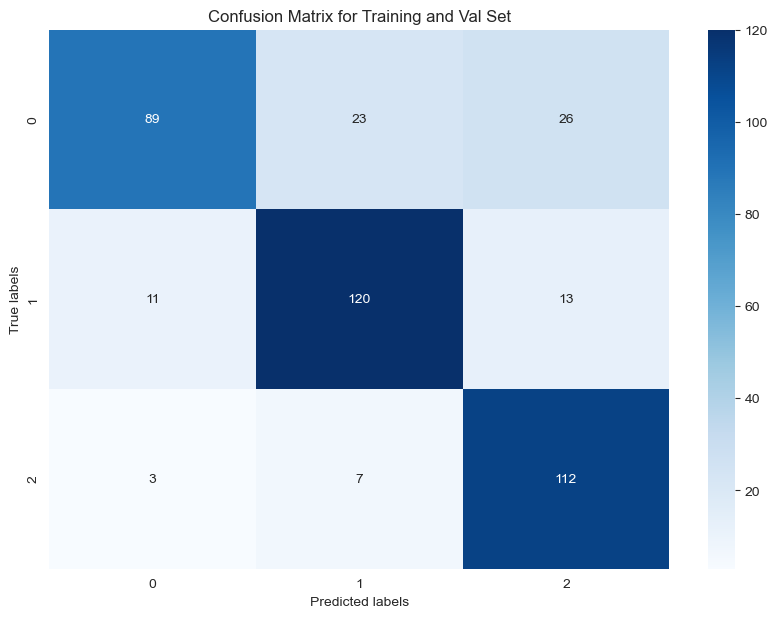

In [14]:
# Predict on the train+validation set to see the performance on the training data
y_train_val_pred = best_pca_lr_model.predict(X_train_val)

# Calculate confusion matrix for the train+validation set
conf_mat_train_val = confusion_matrix(y_train_val, y_train_val_pred)

# Plot the confusion matrix for the train+validation set
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat_train_val, annot=True, fmt='g', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Training and Val Set')
plt.show()

In [15]:
# Get the probability predictions for the test set
y_test_proba = best_pca_lr_model.predict_proba(X_test)
# Clip the probability predictions to avoid log(0) issues
y_test_proba_clipped = np.clip(y_test_proba, 1e-15, 1 - 1e-15)

# Calculate the log loss on the test set again after clipping
logloss_test = log_loss(y_test, y_test_proba_clipped)

logloss_test

0.8768378651345295